In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from fractions import Fraction
import tarjan

In [84]:
def preprocessing(delegations: np.ndarray):
    # 1. Find cycles in the delegations graph
    # 2. Find nodes reachable by a cycle
    # 3. Find the nodes that are not reachable by a cycle

    # 1.
    # https://stackoverflow.com/questions/52322847/what-is-an-efficient-way-to-convert-an-adjacency-matrix-to-a-dictionary
    # Turn the delegations matrix into a dictionary suitable for Tarjan's algorithm
    delegations_dict = {row_idx: np.nonzero(row)[0].tolist() for row_idx,row in enumerate(delegations)}

    SCCs = tarjan.tarjan(delegations_dict)

    # 2.
    nodes_reachable_by_a_cycle = set[int]()

    for scc in SCCs:
        # if the SCC is a cycle
        if len(scc) > 1:
            for node in scc:
                nodes_reachable_by_a_cycle.update(delegations_dict[node])

    # 3.
    nodes_not_reachable_by_a_cycle = set(range(delegations.shape[0])) - nodes_reachable_by_a_cycle

    return (nodes_reachable_by_a_cycle, nodes_not_reachable_by_a_cycle)

In [3]:
def compute_steady_state_delegation_graph(delegations: np.ndarray, initial_power: np.ndarray = None, threshold: float = 1e-9):

    # per node: power = (fixed power, power left to distribute)
    if initial_power is None:
        power = np.column_stack((np.zeros(delegations.shape[0]), np.ones(delegations.shape[0])))
    else:
        power = np.column_stack((np.zeros(delegations.shape[0]), initial_power))

    # Turns the delegations matrix into an adjacency list 
    node_dict = {row_idx: np.nonzero(row)[0].tolist() for row_idx,row in enumerate(delegations.T)} #Can probably be done more efficiently than the transposition currrently

    # Algorithm starts with all nodes
    nodes_to_visit = set(range(delegations.shape[0]))

    counter = 0 # For seeing how long the algorithm ran
    while len(nodes_to_visit) > 0:
        node = nodes_to_visit.pop()

        node_power_to_distribute = power[node, 1]
        power[node, 1] = 0 

        # If the power to distribute is below the threshold, skip the node. 
        # This ensures the algorithm terminates on cycles with a siphon
        if node_power_to_distribute < threshold:
            continue

        for child in node_dict[node]:
            # Add power to the power left to distribute of the child
            power[child, 1] += node_power_to_distribute * delegations[child, node]
            nodes_to_visit.add(child)

        # Add any remaining, undelegated power to the fixed power of the node
        proportion_of_delegated_power = (delegations[:, node].sum())
        power[node, 0] += node_power_to_distribute * (1 - proportion_of_delegated_power)

        counter += 1

    print(f"Algorithm ran {counter} times")

    # Check no power was lost
    print(f"Input power: {delegations.shape[0]}")
    print(f"Output power: {power[:, 0].sum()}")

    return power     

In [199]:
def draw_graph(delegations: np.ndarray, layout_type=nx.spring_layout):
    plt.close("all")
    
    G = nx.from_numpy_array(delegations.T, create_using=nx.MultiDiGraph)
    layout = layout_type(G)

    # Draw graph with curved edges
    nx.draw(G, with_labels=True, pos=layout, connectionstyle="arc3,rad=0.1")

    # Draw edge labels separately for MultiDiGraph
    for u, v, key, data in G.edges(keys=True, data=True):
        label = str(data["weight"])
        # Adjust label position slightly to avoid overlap
        label_pos = (layout[u][0] * 0.55 + layout[v][0] * 0.45, 
                     layout[u][1] * 0.55 + layout[v][1] * 0.45)
        plt.text(label_pos[0], label_pos[1], label)

    plt.show()
    
def distribute_power_and_present_results(delegations: np.ndarray, name: str, graph_layout_type=nx.spring_layout, threshold: float = 1e-9):
    print(f"{name}: \n{compute_steady_state_delegation_graph(delegations, threshold=threshold)}")

    draw_graph(delegations, graph_layout_type)

    print("--------------------")

Algorithm ran 3 times
Input power: 3
Output power: 3.0
Example 4: 
[[0.  0. ]
 [1.6 0. ]
 [1.4 0. ]]


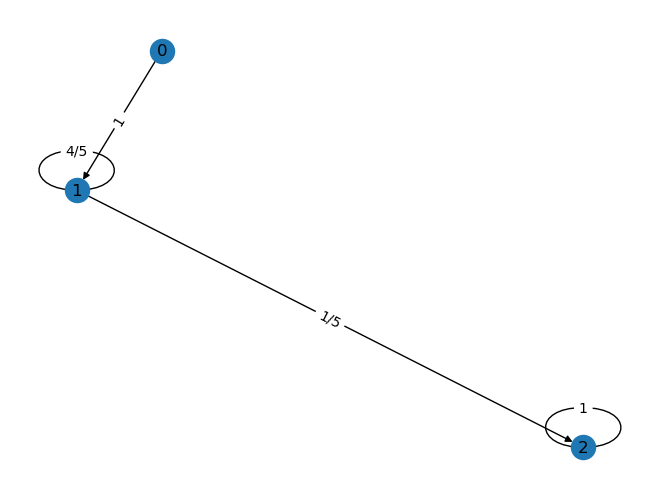

--------------------


In [139]:
THIRD = 1/3

example_4 = np.array([
    [0, 0, 0], 
    [1, 0.8, 0], 
    [0, 0.2, 1]])

print(f"Example 4: \n{compute_steady_state_delegation_graph(example_4)}")

draw_graph(example_4)

print("--------------------")

In [4]:
example_2 = np.array([
    [0, THIRD, 0, 0, 0, 0, THIRD],
    [THIRD, 0, 0, 0, 0, 0, 0],
    [THIRD, 0, 1, 0, 0, 0, 0],
    [THIRD, 0, 0, 1, 0, 0, 0],
    [0, THIRD, 0, 0, 1, 0, 0],
    [0, THIRD, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 2 * THIRD]])

print(f"Example 2: \n{compute_steady_state_delegation_graph(example_2)}")

draw_graph(example_2, layout_type=nx.spectral_layout)

print("--------------------")

NameError: name 'THIRD' is not defined

Algorithm ran 33 times
Input power: 3
Output power: 2.9999999991850927
Test circle output powers: 
[[1. 0.]
 [1. 0.]
 [1. 0.]]


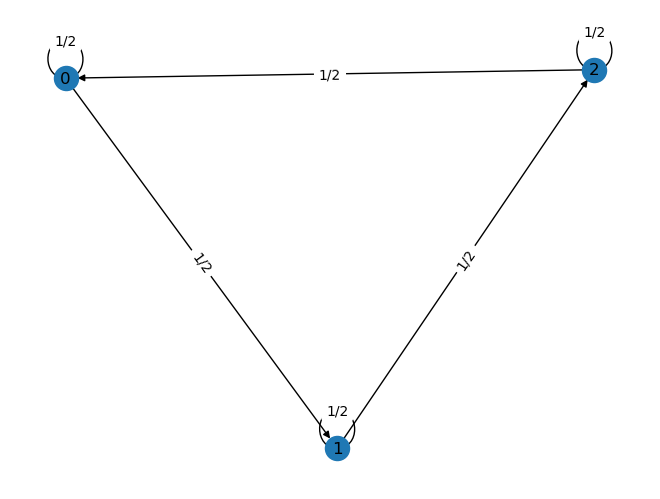

--------------------


In [154]:
test_circle = np.array([
    [0.5, 0, 0.5],
    [0.5, 0.5, 0],
    [0, 0.5, 0.5],
])

print(f"Test circle output powers: \n{compute_steady_state_delegation_graph(test_circle)}")

draw_graph(test_circle)

print("--------------------")

Algorithm ran 375 times
Input power: 5
Output power: 4.999999999999998
Test circle 2: 
[[0.         0.        ]
 [1.07466667 0.        ]
 [1.09333333 0.        ]
 [1.69333333 0.        ]
 [1.13866667 0.        ]]


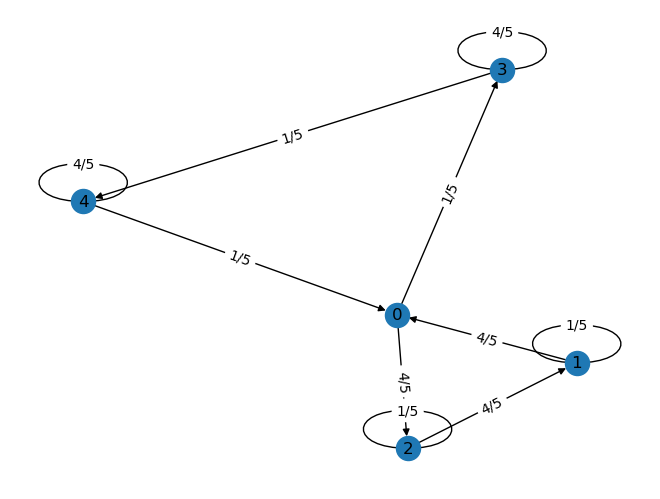

--------------------


In [ ]:
test_circle_2 = np.array([
    [0, 0.8, 0, 0, 0.2],
    [0, 0.2, 0.8, 0, 0],
    [0.8, 0, 0.2, 0, 0],
    [0.2, 0, 0, 0.8, 0],
    [0, 0, 0, 0.2, 0.8],
])

distribute_power_and_present_results(test_circle_2, "Test circle 2", nx.spring_layout)

In [ ]:
circle_size = 1000
test_circle_3 = np.zeros((circle_size, circle_size))

for i in range(circle_size):
    test_circle_3[(i + 1) % circle_size, i] = 0.1
    test_circle_3[i, i] = 0.9

compute_steady_state_delegation_graph(test_circle_3)

Algorithm ran 10020 times
Input power: 10000
Output power: 10000.0


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], shape=(10000, 2))

In [5]:
test_circle_4 = np.array([
    [0.1, 1, 0],
    [0, 0, 1],
    [0.9, 0, 0]])

print(f"{compute_steady_state_delegation_graph(test_circle_4, threshold=1e-9)}")

plt.close("all")

G = nx.from_numpy_array(test_circle_4.T, create_using=nx.DiGraph)

cycles = list(nx.cycle(G))
print(cycles)

layout = nx.spring_layout(G)

for _, _, d in G.edges(data=True):
    d["weight"] = str(Fraction(d["weight"]).limit_denominator())

labels = nx.get_edge_attributes(G, "weight")

nx.draw(G, with_labels=True, pos=layout)
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels)

plt.show()

KeyboardInterrupt: 

Algorithm ran 110 times
Input power: 3
Output power: 2.999999998310479
Davids example: 
[[0.54751131 0.        ]
 [1.77828054 0.        ]
 [0.67420814 0.        ]]


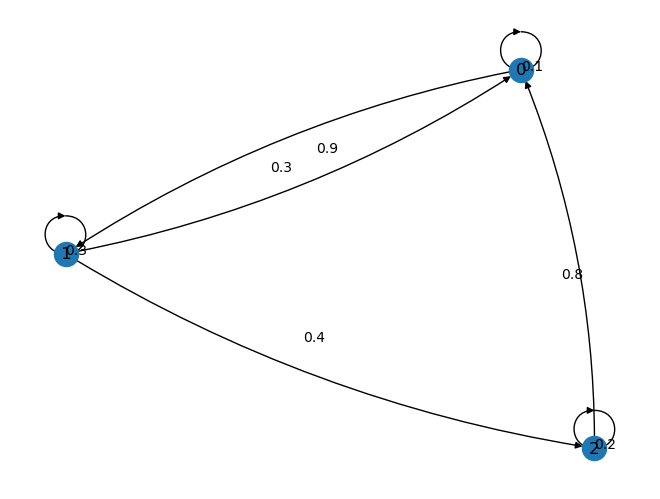

--------------------


In [201]:
davids_example = np.array([
    [0.1, 0.3, 0.8],
    [0.9, 0.3, 0],
    [0, 0.4, 0.2]])

distribute_power_and_present_results(davids_example, "Davids example", nx.spring_layout)